## Assignment 4: Obsevational Studies and Applied ML

### Deadline
November 21st,11:59PM

### Important notes

Make sure you push on GitHub your notebook with all the cells already evaluated. Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you implemented. Back up any hypotheses and claims with data, since this is an important aspect of the course. Please write all your comments in English, and use meaningful variable names in your code. Your repo should have a single notebook (plus the data files necessary) in the master branch. If there are multiple notebooks present, we will not grade anything.

Use this legendary link to create your repository: [link](https://classroom.github.com/g/YXtsr0QK)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
data_folder = './data/'

## Task 1: Boosting the economy by incentivizing self-employment

__Assume the biggest priority of the local government in 2018 is to increase per-capita income. To do so, the officials plan to adopt a strategy for incentivizing self-employment through a series of campaigns, educational programs, and dedicated funds.__

__Since it is unethical and impossible in this setting to run a controlled experiment involving citizens (e.g., fire employees and force them to self-employ), the officials have asked you, the data scientist, to establish the effect of self-employment on the economy, relying on observational data.__

**A)** __You will be working with the full US 2015 census dataset (acs2015_county_data.csv, available at https://www.kaggle.com/muonneutrino/us-census-demographic-data#acs2015_county_data.csv). Using suitable methods, determine and quantify the dependency between the percentage of self-employed citizens and per capita income across all 3,212 US counties. Do citizens in counties that have a higher percentage of self-employed people earn more per capita?__

**B)** __The pilot program will involve all counties within a limited set of three US states. Set A includes Wisconsin, Tennessee, and  Minnesota. Quantify the dependency of per-capita income on self-employment rates across all the counties in set A.__

**C)** __In which state within set A is the observed effect of self-employment on per-capita income the strongest?__

**D)** __Set B includes New Jersey, Kansas, and Rhode Island. Repeat the analysis from steps B and C above, but now for set B. In which of the two sets A and B (if any) would you recommend incentivizing self-employment? Explain your reasoning.__

__Hint: It is useful to add a notion of confidence to your results and explore the data visually. You are allowed to use the SciPy library.__

---
### 1A
__You will be working with the full US 2015 census dataset (acs2015_county_data.csv, available at https://www.kaggle.com/muonneutrino/us-census-demographic-data#acs2015_county_data.csv). Using suitable methods, determine and quantify the dependency between the percentage of self-employed citizens and per capita income across all 3,212 US counties. Do citizens in counties that have a higher percentage of self-employed people earn more per capita?__

#### Loading Phase

Upon loading we notice that according to the dataset there are 3220 counties in the US while the question mentions 3212 counties and wikipedia (https://en.wikipedia.org/wiki/County_(United_States)) says as of 2018 there are 3124 if we don't count county-equivalents (like Alaska boroughs, Louisiana parishes and some independent cities) and 3242 if we do count them. 

Further inspection reveals that, while A LOT of states have counties with the same name (such originality US), there are no repeated entries. Since we don't have a basis to determine who is correct or what (or if) we should cut we'll just stick with our data as it seems consistent enough.

In [3]:
county_data=pd.read_csv(data_folder + 'acs2015_county_data.csv').set_index("CensusId")
county_data.head()

,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
CensusId,,,,,,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


As we can see, we have lots of features, but throughout this task we will only work with ```State```, ```County```, ```IncomePerCap``` and ```SelfEmployed```

#### Cleaning Phase

Now we do some consistency checks. The data seems perfectly fine as is, so we won't need to do cleaning (remember we only care about a few of the columns)

In [4]:
# A list of the columns in the dataset
print(', '.join(county_data.columns.tolist()))

State, County, TotalPop, Men, Women, Hispanic, White, Black, Native, Asian, Pacific, Citizen, Income, IncomeErr, IncomePerCap, IncomePerCapErr, Poverty, ChildPoverty, Professional, Service, Office, Construction, Production, Drive, Carpool, Transit, Walk, OtherTransp, WorkAtHome, MeanCommute, Employed, PrivateWork, PublicWork, SelfEmployed, FamilyWork, Unemployment


In [5]:
print('Number of NaN values in whole table: ' + str(county_data.isnull().sum().sum()) + '\n')
print('Columns where there''s NaN data: ' + ', '.join(county_data.columns[county_data.isnull().any()].tolist()) + '\n')
print('Is the index unique: ' + str(county_data.index.is_unique) + '\n')
print('Number of duplicate counties in our data: ' + str(county_data[county_data[['State','County']].duplicated()].shape[0]))

Number of NaN values in whole table: 3

Columns where theres NaN data: Income, IncomeErr, ChildPoverty

Is the index unique: True

Number of duplicate counties in our data: 0


#### Querying Phase

Now we must quantify the dependency between the percentage of self-employed citizens and per capita income across all 3,220 US counties. We can easily compute te correlation matrix between both variables (per capita income and self employment rate).

In [6]:
county_data[["IncomePerCap", "SelfEmployed"]].corr()

,IncomePerCap,SelfEmployed
IncomePerCap,1.000000,0.087274
SelfEmployed,0.087274,1.000000


In the face of a very low correlation coefficient we can't say that there is a strong linear relation between self-employment rate and income. The following graph shows that same idea:

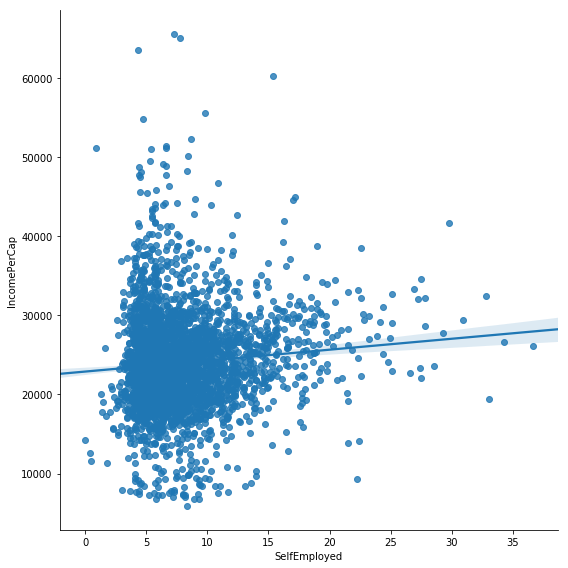

In [7]:
sns.lmplot(x='SelfEmployed', y='IncomePerCap', data=county_data[["IncomePerCap", "SelfEmployed"]], size=8);

### 1B
__The pilot program will involve all counties within a limited set of three US states. Set A includes Wisconsin, Tennessee, and  Minnesota. Quantify the dependency of per-capita income on self-employment rates across all the counties in set A.__

The previous analysis only shows that one cannot claim a strong linear correlation between the two metrics and take sinto consideration all of the counties within the US, which is a big a diverse country. 

It makes sense that within some states (or counties) the correlation could be higher, making the program worth a try, at least in those states (similarly, knowing in advance which states/counties have a high correlation between the metrics and trying the program only in those could be a way of exagerate/downplay the usefulness of such a program by someone with an agenda...)

In [8]:
states    = ["Wisconsin", "Tennessee", "Minnesota"]
setA_data = county_data.loc[county_data['State'].isin(states)]
setA_data = setA_data[["State", "County", "IncomePerCap", "SelfEmployed"]]
setA_data.head(3)

,State,County,IncomePerCap,SelfEmployed
CensusId,,,,
27001,Minnesota,Aitkin,25591,9.2
27003,Minnesota,Anoka,31775,4.2
27005,Minnesota,Becker,26399,9.0


In [9]:
setA_data[["IncomePerCap", "SelfEmployed"]].corr()

,IncomePerCap,SelfEmployed
IncomePerCap,1.000000,-0.202294
SelfEmployed,-0.202294,1.000000


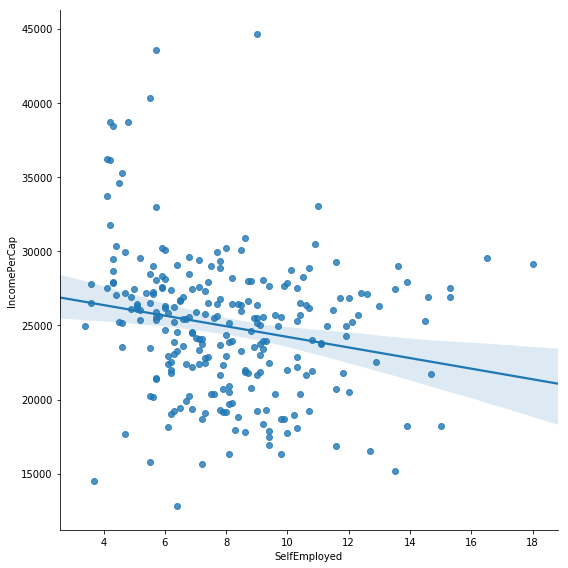

In [10]:
sns.lmplot(x='SelfEmployed', y='IncomePerCap', data=setA_data[["IncomePerCap", "SelfEmployed"]], size=8);

Here, there is a mild correlation of 0.20, and even though the value is much bigger than with the whole US data we still cannot talk about a relation. For the program this is even worse, the correlation is negative, meaning more self-employment is related to less income per capita.

It is worth pointing out that the set has no clear extreme outliers (> 3*IQR) skewing the data.

### 1C
__In which state within set A is the observed effect of self-employment on per-capita income the strongest?__

The effect is the strongest in Wisconsin. Again, note that all of the correlation coefficients are negative.

In [11]:
print('Correlation in Wisconsin: ' + \
      str(setA_data[setA_data["State"]=="Wisconsin"][["IncomePerCap", "SelfEmployed"]].corr().iloc[0]["SelfEmployed"]))

print('Correlation in Tennessee: ' + \
      str(setA_data[setA_data["State"]=="Tennessee"][["IncomePerCap", "SelfEmployed"]].corr().iloc[0]["SelfEmployed"]))

print('Correlation in Minnesota: ' + \
      str(setA_data[setA_data["State"]=="Minnesota"][["IncomePerCap", "SelfEmployed"]].corr().iloc[0]["SelfEmployed"]))

Correlation in Wisconsin: -0.32905300016378525
Correlation in Tennessee: -0.23836048684913153
Correlation in Minnesota: -0.25385519216540625


### 1D
__Set B includes New Jersey, Kansas, and Rhode Island. Repeat the analysis from steps B and C above, but now for set B. In which of the two sets A and B (if any) would you recommend incentivizing self-employment? Explain your reasoning.__

Below we perform the same analysis that we did with set A. The results don't differ much. The correlation coefficient is still negative and not very significant (-0.23).

When we calculate the coefficient for each state we get significantly bigger coefficients for New Jersey (0.48) and Rhode Island (0.90), but this is simply due to lack of data, as those states are small and have very few counties in addition to having very low self-employment rates.

Without looking at anything else, we would not recommend incentivizing self-employment at all, since it doesn't seem to relate to a better income in any case.

In [12]:
states_setB=["New Jersey", "Kansas", "Rhode Island"]
setB_data = county_data.loc[county_data['State'].isin(states_setB)]
setB_data = setB_data[["State", "IncomePerCap", "SelfEmployed"]]
setB_data.head(3)

,State,IncomePerCap,SelfEmployed
CensusId,,,
20001,Kansas,20671,9.1
20003,Kansas,21226,18.7
20005,Kansas,21677,6.0


In [13]:
setB_data[["IncomePerCap", "SelfEmployed"]].corr()

,IncomePerCap,SelfEmployed
IncomePerCap,1.000000,-0.232221
SelfEmployed,-0.232221,1.000000


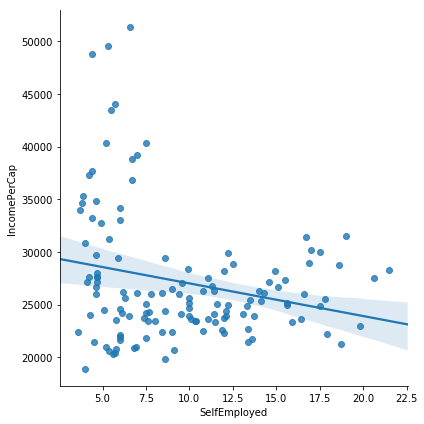

In [14]:
sns.lmplot(x='SelfEmployed', y='IncomePerCap', data=setB_data[["IncomePerCap", "SelfEmployed"]], size=6);

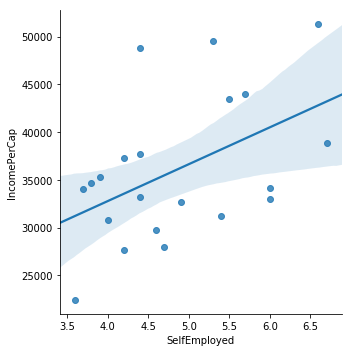

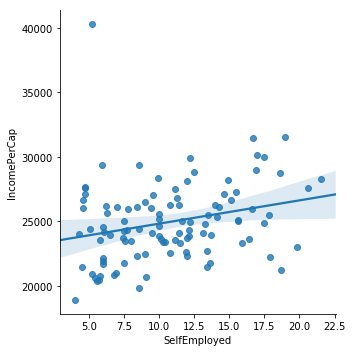

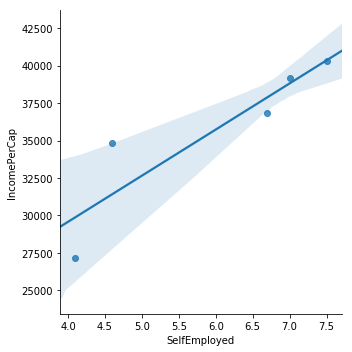

In [15]:
sns.lmplot(x='SelfEmployed', y='IncomePerCap', data=setB_data[setB_data['State'] == 'New Jersey'][["IncomePerCap", "SelfEmployed"]], size=5);
sns.lmplot(x='SelfEmployed', y='IncomePerCap', data=setB_data[setB_data['State'] == 'Kansas'][["IncomePerCap", "SelfEmployed"]], size=5);
sns.lmplot(x='SelfEmployed', y='IncomePerCap', data=setB_data[setB_data['State'] == 'Rhode Island'][["IncomePerCap", "SelfEmployed"]], size=5);

In [16]:
print(setB_data[setB_data["State"]=="New Jersey"][["IncomePerCap", "SelfEmployed"]].corr().iloc[0]["SelfEmployed"])
print(setB_data[setB_data["State"]=="Kansas"][["IncomePerCap", "SelfEmployed"]].corr().iloc[0]["SelfEmployed"])
print(setB_data[setB_data["State"]=="Rhode Island"][["IncomePerCap", "SelfEmployed"]].corr().iloc[0]["SelfEmployed"])

0.4804478471336282
0.2581029971443692
0.9021788382149803


----

## Task 2: All you need is love… And a dog!

__Here we are going to build a classifier to predict whether an animal from an animal shelter will be adopted or not (aac_intakes_outcomes.csv, available at: https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/version/1#aac_intakes_outcomes.csv). You will be working with the following features:__

1. __*animal_type:* Type of animal. May be one of 'cat', 'dog', 'bird', etc.__

2. __*intake_year:* Year of intake__
3. __*intake_condition:* The intake condition of the animal. Can be one of 'normal', 'injured', 'sick', etc.__
4. __*intake_number:* The intake number denoting the number of occurrences the animal has been brought into the shelter. Values higher than 1 indicate the animal has been taken into the shelter on more than one occasion.__
5. __*intake_type:* The type of intake, for example, 'stray', 'owner surrender', etc.__
6. __*sex_upon_intake:* The gender of the animal and if it has been spayed or neutered at the time of intake__
7. __*age_upon\_intake_(years):* The age of the animal upon intake represented in years__
8. __*time_in_shelter_days:* Numeric value denoting the number of days the animal remained at the shelter from intake to outcome.__
9. __*sex_upon_outcome:* The gender of the animal and if it has been spayed or neutered at time of outcome__
10. __*age_upon\_outcome_(years):* The age of the animal upon outcome represented in years__
11. __*outcome_type:* The outcome type. Can be one of ‘adopted’, ‘transferred’, etc.__

**A)** __Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. Standardize the values of each feature in the data to have mean 0 and variance 1. The use of external libraries is not permitted in part A, except for numpy and pandas.__

**B)** __Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold. The shelter has a limited capacity and has no other option but to put to sleep animals with a low probability of adoption. What metric (precision, recall, accuracy, or F1-score) and with respect to what class is the most relevant when choosing the threshold in this scenario, and why? Explain your reasoning.__

**C)** __Reduce the number of features by selecting the subset of the k best features. Use greedy backward selection to iteratively remove features. Evaluate performance and visualize the result using 5-fold cross-validation on the training set as a function of k, where k = 1, 5, 10, 15, 20, 25, 30. Choose the optimal k and justify your choice. Interpret the top-k features and their impact on the probability of adoption.__

**D)** __Train a random forest. Use 5-fold cross-validation on the training set to fine-tune the parameters of the classifier using a grid search on the number of estimators "n_estimators" and the max depth of the trees "max_depth". For the chosen parameters, estimate the performance of your classifier on the test set by presenting the confusion matrix, accuracy, precision, recall, and F1-score with respect to both classes and compare the performance with the performance of the logistic regression. Interpret the results.__

__You are allowed to use the scikit-learn library to implement your classifiers.__

---
### 2A

__Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. Standardize the values of each feature in the data to have mean 0 and variance 1. The use of external libraries is not permitted in part A, except for numpy and pandas.__

#### Loading Phase

Let us first load the dataset with the approriate features (columns) and print the head and the tail of the dataframe

In [17]:
features = ['animal_type','intake_year','intake_condition','intake_number','intake_type','sex_upon_intake', \
            'age_upon_intake_(years)','time_in_shelter_days','sex_upon_outcome','age_upon_outcome_(years)', \
            'outcome_type']

df = pd.read_csv(data_folder + 'aac_intakes_outcomes.csv', usecols=features)

In [18]:
df.head(3)

,outcome_type,sex_upon_outcome,age_upon_outcome_(years),animal_type,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days
0,Return to Owner,Neutered Male,10.0,Dog,Normal,Stray,Neutered Male,10.0,2017,1.0,0.588194
1,Return to Owner,Neutered Male,7.0,Dog,Normal,Public Assist,Neutered Male,7.0,2014,2.0,1.259722
2,Return to Owner,Neutered Male,6.0,Dog,Normal,Public Assist,Neutered Male,6.0,2014,3.0,1.113889


#### Cleaning Phase

From the dataframe we can see that there are 5 catgorical features (excluding outcome type):
1. __*animal_type:*__ Type of animal. May be one of 'cat', 'dog', 'bird', etc.
2. __*intake_condition:*__ The intake condition of the animal. Can be one of 'normal', 'injured', 'sick', etc.
3. __*intake_type:*__ The type of intake, for example, 'stray', 'owner surrender', etc.
4. __*sex_upon_intake:*__ The gender of the animal and if it has been spayed or neutered at the time of intake
5. __*sex_upon_outcome:*__ The gender of the animal and if it has been spayed or neutered at time of outcome

We can confirm this by checking the type of data for each feature:

In [19]:
df.dtypes

outcome_type                 object
sex_upon_outcome             object
age_upon_outcome_(years)    float64
animal_type                  object
intake_condition             object
intake_type                  object
sex_upon_intake              object
age_upon_intake_(years)     float64
intake_year                   int64
intake_number               float64
time_in_shelter_days        float64
dtype: object

As we can see the five features mentionned above (excluding outcome_type) are the only categorical features (type object).

Let's inspect these features closely

In [20]:
categorical_features = ['sex_upon_outcome','animal_type','intake_condition','intake_type', \
                        'sex_upon_intake']
for feat in features:
    print(feat + ':')
    print(df[feat].value_counts())

animal_type:
Dog      45366
Cat      29539
Other     4428
Bird       339
Name: animal_type, dtype: int64
intake_year:
2015    18699
2014    18645
2016    17632
2017    17440
2013     4178
2018     3078
Name: intake_year, dtype: int64
intake_condition:
Normal      70056
Injured      3997
Sick         3099
Nursing      1915
Aged          319
Other         147
Feral          92
Pregnant       47
Name: intake_condition, dtype: int64
intake_number:
1.0     71993
2.0      6052
3.0      1152
4.0       302
5.0       101
6.0        39
7.0        15
8.0         7
9.0         3
11.0        3
10.0        3
13.0        1
12.0        1
Name: intake_number, dtype: int64
intake_type:
Stray                 55935
Owner Surrender       15028
Public Assist          4994
Wildlife               3464
Euthanasia Request      251
Name: intake_type, dtype: int64
sex_upon_intake:
Intact Male      25317
Intact Female    23704
Neutered Male    12708
Spayed Female    11153
Unknown           6789
Name: sex_upon_inta

Since there are no NaN, There is one last preprocessing task we could do. Since we are interested in adopted or not adopted, we can map the outcome_type to 1 for adopted and 0 for any other category

In [21]:
df['outcome_type'] = df['outcome_type'].map({'Adoption':1}).fillna(value=0)

As we can see below there are only 1 and 0 reamining for adoption or not adoption respectively.

In [22]:
df['outcome_type'].value_counts()

0.0    46078
1.0    33594
Name: outcome_type, dtype: int64

In order to perform dummy variable encoding on the categorical features (outcome_type excluded), we can use the pandas method `pd.get_dummies()`. Also since we need k-1 dummy variables to represent k categories, we can drop the first column for each encoding (`drop_first = True`). We'll store this as a new dataframe `dummy_df`.

In [23]:
dummy_df = pd.get_dummies(df,columns=categorical_features,drop_first=False)
dummy_df.head(3)

,outcome_type,age_upon_outcome_(years),age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,...,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,intake_type_Wildlife,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown
0,0.0,10.0,10.0,2017,1.0,0.588194,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1,0.0,7.0,7.0,2014,2.0,1.259722,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
2,0.0,6.0,6.0,2014,3.0,1.113889,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0


We standardize the features in preparation for training.

In [24]:
for feat in dummy_df.columns.tolist()[1:]:
    mean = dummy_df[feat].mean()
    std = dummy_df[feat].std()
    dummy_df[feat] = (dummy_df[feat] - mean)/std

In order to split the data into the two sets (training and test), we can use the sample method (`pd.sample()`) which  randomly samples from the dataframe according to a given ratio (0.8 for train in this case). The remaining part of the data will be the test set.

In [25]:
train_df = dummy_df.sample(frac=0.8,replace=False)
test_df = dummy_df.drop(train_df.index.tolist(),axis=0)

In [26]:
train_df.head(3)

,outcome_type,age_upon_outcome_(years),age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,...,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,intake_type_Wildlife,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown
66881,1.0,-0.682123,-0.702022,1.200085,-0.278079,0.937294,-0.363706,-0.373023,1.347568,-0.687058,...,-0.056217,-0.482152,-0.258598,0.651431,-0.213199,-0.650786,1.465247,-0.435627,-0.403448,-0.305202
68258,0.0,-0.393987,-0.382896,1.200085,-0.278079,-0.300063,-0.363706,-0.373023,-0.742068,1.455463,...,-0.056217,-0.482152,-0.258598,0.651431,-0.213199,1.536584,-0.682470,-0.435627,-0.403448,-0.305202
79606,0.0,-0.393987,-0.382896,1.967453,-0.278079,-0.400199,-0.363706,-0.373023,-0.742068,-0.687058,...,-0.056217,-0.482152,-0.258598,-1.535063,4.690386,-0.650786,-0.682470,-0.435627,-0.403448,3.276480


In [27]:
test_df.head(3)

,outcome_type,age_upon_outcome_(years),age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,...,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,intake_type_Wildlife,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown
6,0.0,4.433469,4.456078,-1.102017,-0.278079,-0.397766,2.749441,-0.373023,-0.742068,-0.687058,...,-0.056217,-0.482152,-0.258598,0.651431,-0.213199,1.536584,-0.68247,-0.435627,-0.403448,-0.305202
7,0.0,4.433469,4.456078,-1.102017,-0.278079,-0.396933,-0.363706,-0.373023,1.347568,-0.687058,...,-0.056217,-0.482152,-0.258598,0.651431,-0.213199,-0.650786,-0.68247,2.295511,-0.403448,-0.305202
12,1.0,4.778288,4.801719,-1.869384,-0.278079,0.791538,-0.363706,-0.373023,1.347568,-0.687058,...,-0.056217,2.074010,-0.258598,-1.535063,-0.213199,-0.650786,-0.68247,2.295511,-0.403448,-0.305202


Quick check of the validity of the split by making sure that the size of the train plus the size of the test equals the size of the dummy:

In [28]:
print(train_df.shape[0] + test_df.shape[0] == dummy_df.shape[0])

True


Double check the mean of the features

In [29]:
dummy_df.mean()[1:]

age_upon_outcome_(years)          2.951286e-13
age_upon_intake_(years)           2.443235e-13
intake_year                      -1.842674e-13
intake_number                    -4.830955e-14
time_in_shelter_days             -7.573476e-16
sex_upon_outcome_Intact Female   -1.056339e-14
sex_upon_outcome_Intact Male     -1.796153e-15
sex_upon_outcome_Neutered Male   -8.527634e-15
sex_upon_outcome_Spayed Female   -8.709942e-15
sex_upon_outcome_Unknown          3.291075e-14
animal_type_Bird                 -7.117165e-15
animal_type_Cat                  -2.400798e-14
animal_type_Dog                  -3.465862e-14
animal_type_Other                 2.993477e-15
intake_condition_Aged            -9.982576e-15
intake_condition_Feral            2.357509e-15
intake_condition_Injured         -1.280683e-15
intake_condition_Normal          -1.518089e-14
intake_condition_Nursing         -1.136080e-14
intake_condition_Other           -8.404619e-16
intake_condition_Pregnant         2.779437e-15
intake_condit

The means aren't exactly 0 but they are small enough for us to approximate them to 0.

Now for the standart deviation

In [30]:
dummy_df.std()[1:]

age_upon_outcome_(years)          1.0
age_upon_intake_(years)           1.0
intake_year                       1.0
intake_number                     1.0
time_in_shelter_days              1.0
sex_upon_outcome_Intact Female    1.0
sex_upon_outcome_Intact Male      1.0
sex_upon_outcome_Neutered Male    1.0
sex_upon_outcome_Spayed Female    1.0
sex_upon_outcome_Unknown          1.0
animal_type_Bird                  1.0
animal_type_Cat                   1.0
animal_type_Dog                   1.0
animal_type_Other                 1.0
intake_condition_Aged             1.0
intake_condition_Feral            1.0
intake_condition_Injured          1.0
intake_condition_Normal           1.0
intake_condition_Nursing          1.0
intake_condition_Other            1.0
intake_condition_Pregnant         1.0
intake_condition_Sick             1.0
intake_type_Euthanasia Request    1.0
intake_type_Owner Surrender       1.0
intake_type_Public Assist         1.0
intake_type_Stray                 1.0
intake_type_

Hence our standardized features and our labels are ready to go.

### 2B
__Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold. The shelter has a limited capacity and has no other option but to put to sleep animals with a low probability of adoption. What metric (precision, recall, accuracy, or F1-score) and with respect to what class is the most relevant when choosing the threshold in this scenario, and why? Explain your reasoning.__

In order to train our classifier, we first need to get the feature data and the labels from our training set

In [31]:
new_features = dummy_df.columns.tolist()[1:]

x_train = train_df[new_features]
y_train = train_df['outcome_type']

Let us now define our classifier

In [32]:
logistic = LogisticRegression(solver='lbfgs')
logistic

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

The classifier can be trained using the `fit()` method

In [33]:
logistic.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In order to determine the performance of our classifier, we shall use it to predict the classification of the test set and hence by comparing with the actual class, we will determine accuracy, precision, recall and F1 score, with respect to both clases. In this case we shall set `adopted = 1` and `not adopted = 0`.

In [34]:
#threshold used to determine the labels based on the prediction probabilites
threshold = 0.5

#predict the labels using the classifier and convert the results into a pandas dataframe.
pred = pd.DataFrame(logistic.predict_proba(test_df[new_features])).iloc[:,0].apply(lambda x: 0 if x>threshold else 1) \
                    .to_frame()
pred.columns = ['Adopted']
pred.head(3)

,Adopted
0,0
1,0
2,0


We shall now put the predicted results with the actual results in the same dataframe.

In [35]:
perf_df = pd.concat([test_df['outcome_type'].reset_index(),pred],axis=1)[['outcome_type','Adopted']]
perf_df.columns = ['class','classification']
perf_df.head()

,class,classification
0,0.0,0
1,0.0,0
2,1.0,0
3,1.0,0
4,0.0,0


We can now start to analyze the data and determine the True positive (TP), True negative (TN), False positive (FP) and False negative (FN). They are defined as such:
1. TP = adopted and prediction adopted
2. TN = not adopted and prediction not adopted
3. FP = not adopted and prediction adopted
4. FN = adopted and prediction not adopted

In [36]:
#Get the appropriate subdataframes from perf_df for merging later
class_adopted = perf_df[perf_df['class'] == 1.0][['class']]
class_not_adopted = perf_df[perf_df['class'] == 0.0][['class']]
classification_adopted = perf_df[perf_df['classification'] == 1.0][['classification']]
classification_not_adopted = perf_df[perf_df['classification'] == 0.0][['classification']]

One way to find out the four values above, we can merge the above dataframe with the pandas `merge()` method. One advantage of this method is that the merge is full outer join and hence we can just take the count.

In [37]:
TP = pd.merge(class_adopted,classification_adopted,left_index=True,right_index=True).shape[0]
TN = pd.merge(class_not_adopted,classification_not_adopted,left_index=True,right_index=True).shape[0]
FP = pd.merge(class_not_adopted,classification_adopted,left_index=True,right_index=True).shape[0]
FN = pd.merge(class_adopted,classification_not_adopted,left_index=True,right_index=True).shape[0]

We can now build our confusion matrix. (For the positive class)

In [38]:
confusion_matrix = pd.DataFrame([[TP,FP],[FN,TN]])
confusion_matrix

,0,1
0,5477,1672
1,1178,7607


For the negative class:

In [39]:
confusion_matrix2 = pd.DataFrame([[TN,FN],[FP,TP]])
confusion_matrix2

,0,1
0,7607,1178
1,1672,5477


We can now establish the classifier's performance. For the second class we will just add a 2 athe end of the variable.

In [40]:
# Positive class
accuracy = (TP + TN)/(TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2*precision*recall / (precision + recall)

# Negative class
accuracy2 = (TP + TN)/(TP + TN + FP + FN)
precision2 = TN / (TN + FN)
recall2 = TN / (TN + FP)
f1_score2 = 2*precision2*recall2 / (precision2 + recall2)

performances1 = pd.DataFrame([[accuracy,precision,recall,f1_score]], columns=['accuracy','precision','recall','f1score'])
performances2 = pd.DataFrame([[accuracy2,precision2,recall2,f1_score2]], columns=['accuracy2','precision2','recall2','f1score2'])

Performance with respect to the positive class

In [41]:
performances1

,accuracy,precision,recall,f1score
0,0.821137,0.766121,0.82299,0.793538


Performance with respect to the negative class

In [42]:
performances2

,accuracy2,precision2,recall2,f1score2
0,0.821137,0.865908,0.819808,0.842228


As we can see, for a threshold of 0.5, the precision, recall and f1 score is higher with respect to the negative class. Accuracy is the same in both cases (as it should be).

Next we want to test the effects of a varying threshold on the classifier's perfromance. Hence we took the above script and made a method which returns the performances and the confusion matrices (with respect to both clases) given a prediction and the correct results.

In [43]:
def get_perf_two_cases(class_df,classification_df):
    perf_df = pd.concat([class_df,classification_df],axis=1)
    perf_df.columns = ['class','classification']
    
    class_adopted = perf_df[perf_df['class'] == 1.0][['class']]
    class_not_adopted = perf_df[perf_df['class'] == 0.0][['class']]
    classification_adopted = perf_df[perf_df['classification'] == 1.0][['classification']]
    classification_not_adopted = perf_df[perf_df['classification'] == 0.0][['classification']]
    
    TP = pd.merge(class_adopted,classification_adopted,left_index=True,right_index=True).shape[0]
    TN = pd.merge(class_not_adopted,classification_not_adopted,left_index=True,right_index=True).shape[0]
    FP = pd.merge(class_not_adopted,classification_adopted,left_index=True,right_index=True).shape[0]
    FN = pd.merge(class_adopted,classification_not_adopted,left_index=True,right_index=True).shape[0]
    
    accuracy = (TP + TN)/(TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2*precision*recall / (precision + recall)
    
    accuracy2 = (TP + TN)/(TP + TN + FP + FN)
    precision2 = TN / (TN + FN)
    recall2 = TN / (TN + FP)
    f1_score2 = 2*precision2*recall2 / (precision2 + recall2)

    performances = pd.DataFrame([[accuracy,precision,recall,f1_score]], columns=['accuracy','precision','recall', \
                                                                                 'f1score'])
    performances2 = pd.DataFrame([[accuracy2,precision2,recall2,f1_score2]], columns=['accuracy2','precision2','recall2', \
                                                                                 'f1score2'])
    
    confusion_matrix = pd.DataFrame([[TP,FP],[FN,TN]])                                                                             
    confusion_matrix2 = pd.DataFrame([[TN,FN],[FP,TP]])
    
    return (performances,performances2, confusion_matrix, confusion_matrix2)
    

We shall now evaluate the performance of our classifier with thresholds varying from 0.01 to 0.99 in steps of 0.01.

In [44]:
performance_results1 = pd.DataFrame([],columns=['accuracy','precision','recall','f1score'])
performance_results2 = pd.DataFrame([],columns=['accuracy2','precision2','recall2','f1score2'])
thresholds = pd.DataFrame([i/100 for i in range(1,101)],columns = ['threshold'])

for i in range(1,100):
    threshold = i/100
    pred = pd.DataFrame(logistic.predict_proba(test_df[new_features])).iloc[:,0].apply(lambda x: 0 if x>threshold else 1).to_frame()
    performance_results1 = pd.concat([performance_results1,get_perf_two_cases(test_df['outcome_type'].reset_index()[['outcome_type']],pred)[0]], axis = 0)
    performance_results2 = pd.concat([performance_results2,get_perf_two_cases(test_df['outcome_type'].reset_index()[['outcome_type']],pred)[1]], axis = 0)

performance_results1 = pd.concat([thresholds,performance_results1.reset_index().iloc[:,1:]],axis=1).iloc[:-1,:]
performance_results2 = pd.concat([thresholds,performance_results2.reset_index().iloc[:,1:]],axis=1).iloc[:-1,:]

Let us now plot these scores on the same plot at first just to get a general idead of our classifier's performance.

First for the positive class

<Figure size 1080x1080 with 0 Axes>

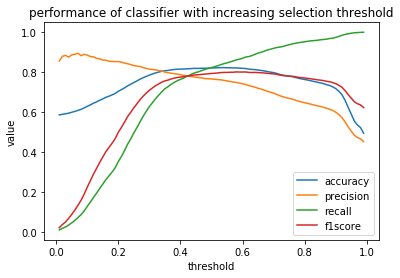

In [45]:
fig = plt.figure(figsize=(15,15))
performance_results1.set_index('threshold').plot()
plt.title("performance of classifier with increasing selection threshold")
plt.ylabel("value")
plt.show()

Let us now plot them individually 

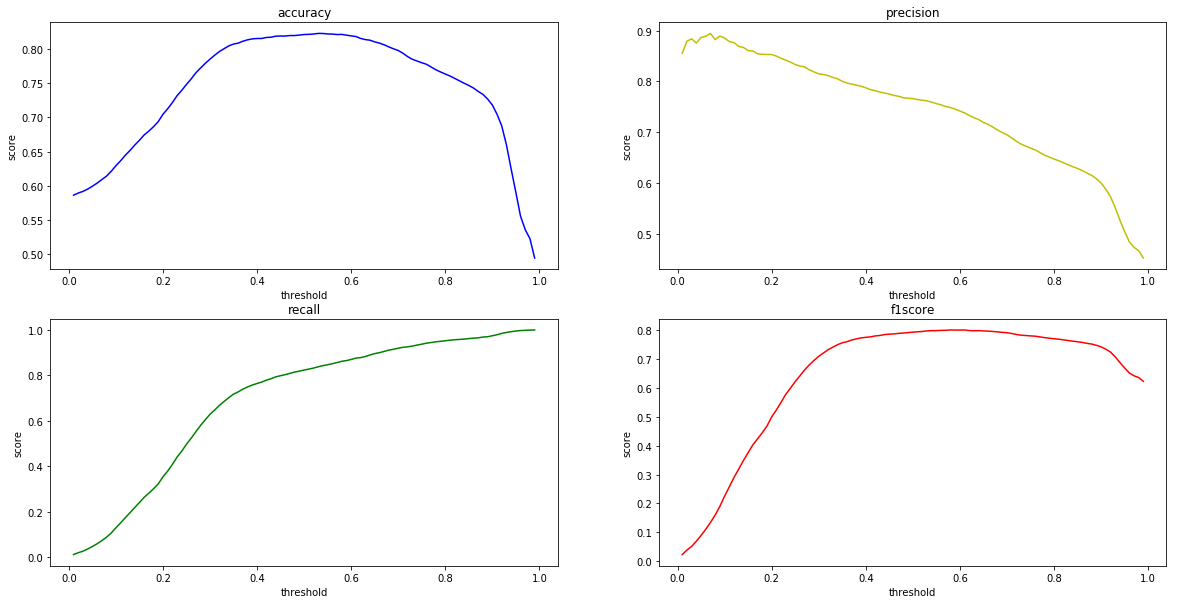

In [46]:
fig = plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.plot(performance_results1['threshold'], performance_results1['accuracy'], 'b-')
plt.title('accuracy')
plt.xlabel('threshold')
plt.ylabel('score')
plt.subplot(2,2,2)
plt.plot(performance_results1['threshold'], performance_results1['precision'], 'y-')
plt.title('precision')
plt.xlabel('threshold')
plt.ylabel('score')
plt.subplot(2,2,3)
plt.plot(performance_results1['threshold'], performance_results1['recall'], 'g-')
plt.title('recall')
plt.xlabel('threshold')
plt.ylabel('score')
plt.subplot(2,2,4)
plt.plot(performance_results1['threshold'], performance_results1['f1score'], 'r-')
plt.title('f1score')
plt.xlabel('threshold')
plt.ylabel('score')

plt.show()

Next for the negative case

<Figure size 1080x1080 with 0 Axes>

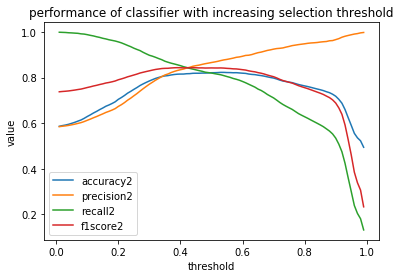

In [47]:
fig = plt.figure(figsize=(15,15))
performance_results2.set_index('threshold').plot()
plt.title("performance of classifier with increasing selection threshold")
plt.ylabel("value")
plt.show()

Let us now plot them individually 

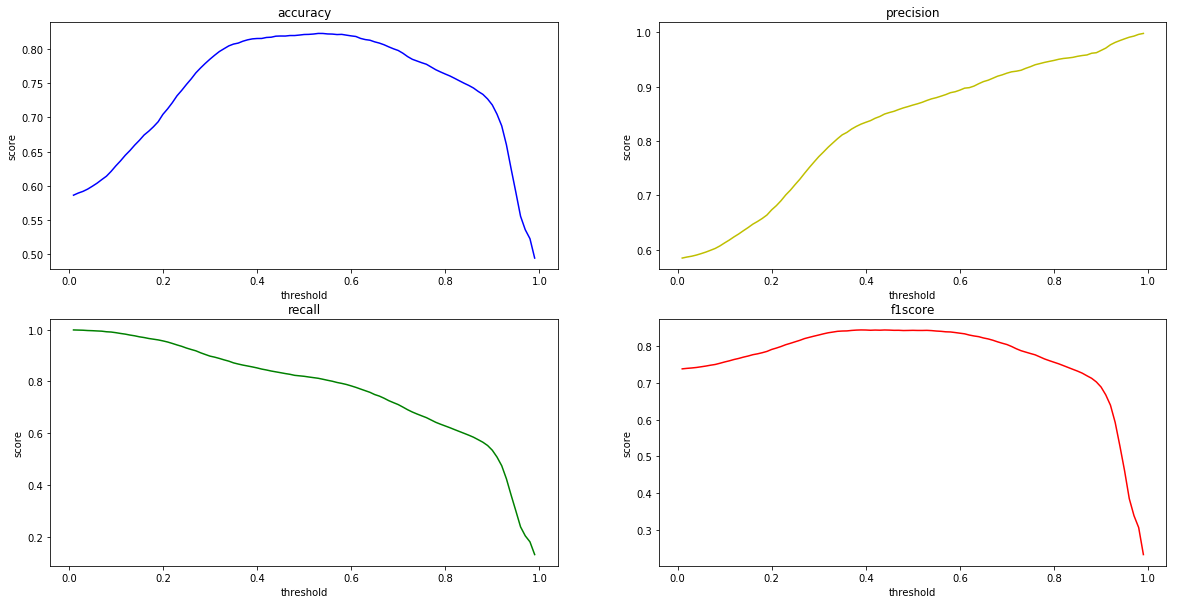

In [48]:
fig = plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.plot(performance_results2['threshold'], performance_results2['accuracy2'], 'b-')
plt.title('accuracy')
plt.xlabel('threshold')
plt.ylabel('score')
plt.subplot(2,2,2)
plt.plot(performance_results2['threshold'], performance_results2['precision2'], 'y-')
plt.title('precision')
plt.xlabel('threshold')
plt.ylabel('score')
plt.subplot(2,2,3)
plt.plot(performance_results2['threshold'], performance_results2['recall2'], 'g-')
plt.title('recall')
plt.xlabel('threshold')
plt.ylabel('score')
plt.subplot(2,2,4)
plt.plot(performance_results2['threshold'], performance_results2['f1score2'], 'r-')
plt.title('f1score')
plt.xlabel('threshold')
plt.ylabel('score')

plt.show()

Let us now put the metrics side by side (positive class on the left, negative class on the right)

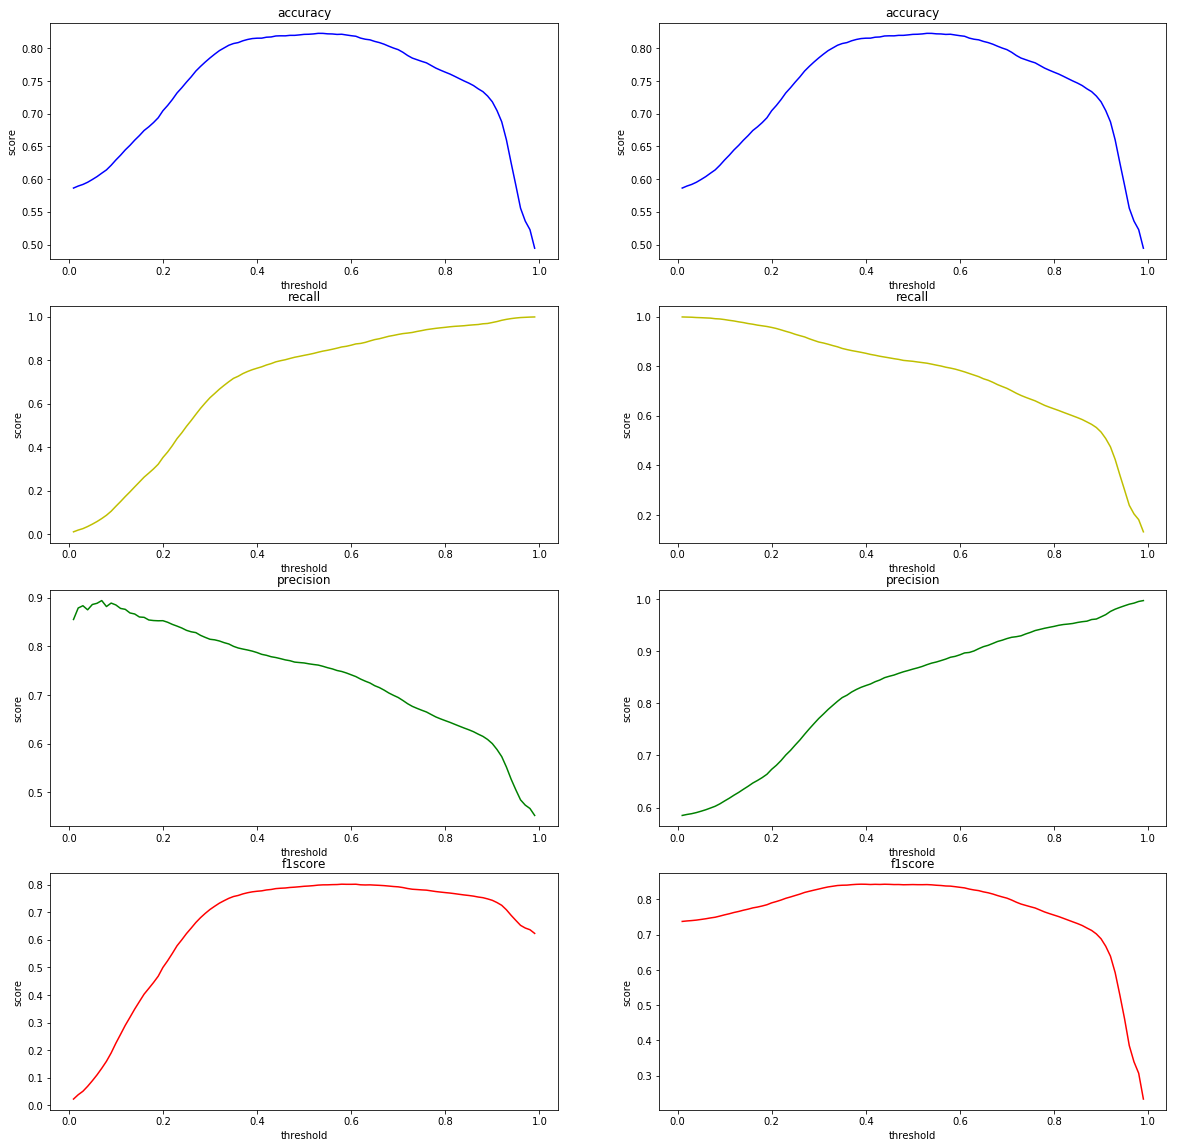

In [49]:
fig = plt.figure(figsize=(20,20))
plt.subplot(4,2,1)
plt.plot(performance_results1['threshold'], performance_results1['accuracy'], 'b-')
plt.title('accuracy')
plt.xlabel('threshold')
plt.ylabel('score')
plt.subplot(4,2,2)
plt.plot(performance_results2['threshold'], performance_results2['accuracy2'], 'b-')
plt.title('accuracy')
plt.xlabel('threshold')
plt.ylabel('score')
plt.subplot(4,2,3)
plt.plot(performance_results1['threshold'], performance_results1['recall'], 'y-')
plt.title('recall')
plt.xlabel('threshold')
plt.ylabel('score')
plt.subplot(4,2,4)
plt.plot(performance_results2['threshold'], performance_results2['recall2'], 'y-')
plt.title('recall')
plt.xlabel('threshold')
plt.ylabel('score')
plt.subplot(4,2,5)
plt.plot(performance_results1['threshold'], performance_results1['precision'], 'g-')
plt.title('precision')
plt.xlabel('threshold')
plt.ylabel('score')
plt.subplot(4,2,6)
plt.plot(performance_results2['threshold'], performance_results2['precision2'], 'g-')
plt.title('precision')
plt.xlabel('threshold')
plt.ylabel('score')
plt.subplot(4,2,7)
plt.plot(performance_results1['threshold'], performance_results1['f1score'], 'r-')
plt.title('f1score')
plt.xlabel('threshold')
plt.ylabel('score')
plt.subplot(4,2,8)
plt.plot(performance_results2['threshold'], performance_results2['f1score2'], 'r-')
plt.title('f1score')
plt.xlabel('threshold')
plt.ylabel('score')


plt.show()

As we can see, to derive the graph from the positive class to the negative class and vice-versa, we can just invert the x-axis (mirror image). Except for the accuracy which is the same with respect to both classes.

For the accuracy, we can see that we reach a maximum for a threshold around 0.5, which makes sense because accuracy represents the ratio of missclassifications (positive and negative).

For the recall, we can see that in the positive class: increasing the threshold, increases the score and for the negative class: increasing threshold, decreases the score.



As to which metric to use, we need to remember that this involves lives, so what we want is to make sure that we don't kill any animal unless we're extremely sure that they won't be adopted a.k.a. minimize false negatives. Maximizing recall minimizes false negatives, so we would use this metric.

### 2C
__Reduce the number of features by selecting the subset of the k best features. Use greedy backward selection to iteratively remove features. Evaluate performance and visualize the result using 5-fold cross-validation on the training set as a function of k, where k = 1, 5, 10, 15, 20, 25, 30. Choose the optimal k and justify your choice. Interpret the top-k features and their impact on the probability of adoption.__

In [50]:
lr = LogisticRegression(solver='lbfgs')

x_train = train_df.iloc[:,1:]
y_train = train_df.iloc[:,0]

x_test = test_df.iloc[:,1:]
y_test = test_df.iloc[:,0]

Implement cross-validation

In [ ]:
def cv_5_fold(method, X, y):
    
    # split data
    size = len(X)
    fold_size = np.floor(len(X)/5)
    fold_index = np.array([0, np.floor(size/fold_size), 2*np.floor(size/fold_size), \
                  3*np.floor(size/fold_size), 4*np.floor(size/fold_size), size-1])
    fold_index = fold_index.astype(int)
    
    accuracies = []
    
    # train
    for i in np.arange(0,5):
        X_train = pd.concat([X.iloc[fold_index[0]:fold_index[i]-1], X.iloc[fold_index[i+1]:size-1]], axis=0)
        X_test  = X.iloc[fold_index[i]:fold_index[i+1]]
        
        y_train = pd.concat([y.iloc[fold_index[0]:fold_index[i]-1,:], y.iloc[fold_index[i+1]:size-1,:]], axis=0)
        y_test  = y.iloc[fold_index[i]:fold_index[i+1]]
        
        method.fit(X_train, y_train)
        pred = pd.DataFrame(method.predict_proba(X_test)).iloc[:,0].apply(lambda x: 0 if x > 0.5 else 1)
        accuracies.append(get_perf_two_cases(y_test.reset_index()['outcome_type'],pred)[0]['accuracy'])
    
    return accuracies

Having done that we use greedy backward selection; removing every time (until we have just one feature) the feature that without it, we obtain the model (through cross_validation) with the best accuracy. We also save the best accuracy for every number of features (k) used to construct the model in the data frame `scores`, so that we will get a plot for visualizing the results easily.

In [52]:
optimal_df = x_train
scores = pd.DataFrame([],columns=['k_features','best_accuracy'])
for k in range(x_train.shape[1]-1,0,-1):
    best_accuracy=0
    #In this data frame we are going to introduce the accuracy obtained when removing each feature
    perf_val = pd.DataFrame([],columns=['removed_feature','accuracy'])
    for feat in optimal_df.columns:
        accuracy = cross_val_score(lr,optimal_df.drop([feat],axis=1),y_train,cv=5,scoring='accuracy').mean()
        perf_val = pd.concat([perf_val,pd.DataFrame([[feat,accuracy]],columns = ['removed_feature','accuracy'])])
        
        if best_accuracy<accuracy:
            best_accuracy = accuracy
        
    worst_feat = perf_val.max()[0]
    optimal_df = optimal_df.drop([worst_feat],axis=1)
    #print(best_accuracy)
    scores= pd.concat([scores,pd.DataFrame([[k,best_accuracy]],columns = ['k_features','best_accuracy'])], sort=False)
    
scores=scores.set_index("k_features")

Thus, we obtain the menthioned data frame with the best accuracy obtained using k features (for creating the prediction model)

In [53]:
scores.head()

,best_accuracy
k_features,
31,0.822759
30,0.810490
29,0.810490
28,0.810490
27,0.810490


And simply create a plot from this data frame obtaining a good visualization: 

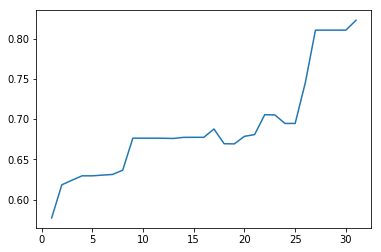

In [54]:
plt.plot(scores.index,scores['best_accuracy']);

So we can clearly see that the best model (which produce the best accuracy) is the one obtained by all the features (k=31). We also check that usually the accuracy is better when we have more features for creating the model, however there are cases when removing a feature do not influence in the accuracy or even makes it greater. We could interpret that this features are introducing noise in our model (when we have already removed other features)

### 2D
__Train a random forest. Use 5-fold cross-validation on the training set to fine-tune the parameters of the classifier using a grid search on the number of estimators "n_estimators" and the max depth of the trees "max_depth". For the chosen parameters, estimate the performance of your classifier on the test set by presenting the confusion matrix, accuracy, precision, recall, and F1-score with respect to both classes and compare the performance with the performance of the logistic regression. Interpret the results.__

RandomForestClassifier(n_estimators=’warn’, criterion=’gini’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None)

Firstly, we do grid search on the number of estimators "n_estimators" and the max depth of the trees "max_depth". We decide to use the accuracy as a criteria for comparing the quality of the diferents models (created by differents "n_estimators" and "max_depth"). So, we compute a data frame with the accuracy for every pair (n_estimators, max_depth) explorated.

In [55]:
performance_results = pd.DataFrame(columns=['n_estimators', 'max_depth','accuracy'])

n=5
for i in range(1, n):
    for j in range(1, n):
        n_esti = i*10
        m_depth = 10 + j*2
        forestC = RandomForestClassifier(n_estimators=n_esti, max_depth=m_depth)
        accuracy = cross_val_score(forestC, x_train, y_train, cv = 5, scoring='accuracy').mean()
        performance_results.loc[i*n+j-n-1] = [n_esti, m_depth,accuracy]  #i*n-n-1 to access to the correct index

performance_results.head()

,n_estimators,max_depth,accuracy
0,10.0,12.0,0.851501
1,10.0,14.0,0.852600
2,10.0,16.0,0.853870
3,10.0,18.0,0.849352
5,20.0,12.0,0.852207


Now, we sort the data frame by the accuracy and chosee the parameters  "n_estimators" and "max_depth" which have achieve the best accuracy.

In [56]:
performance_results

,n_estimators,max_depth,accuracy
0,10.0,12.0,0.851501
1,10.0,14.0,0.852600
2,10.0,16.0,0.853870
3,10.0,18.0,0.849352
5,20.0,12.0,0.852207
6,20.0,14.0,0.854231
7,20.0,16.0,0.854012
8,20.0,18.0,0.852317
10,30.0,12.0,0.852960
11,30.0,14.0,0.854796


In [57]:
performance_results.sort_values(by="accuracy", ascending=False).head(1)

,n_estimators,max_depth,accuracy
16,40.0,14.0,0.855486


Thus, we choose these values for both parameters and compute our predictions: 

In [129]:
n_esti=30
m_depth=14
forestC=RandomForestClassifier(n_estimators=n_esti, max_depth=m_depth)
predicted= cross_val_predict(forestC,x_train, y_train, cv = 5)
predicted

array([0., 1., 0., ..., 1., 0., 0.])

Having done this, it is easy to compute the confusin matrix, accuracy, recall, precision and f1 using the function `get_perf_two_cases` defined in part B. This function will return a vector with the accuracy, precision, recall, and F1-score with respect to both classes, and also the confusion matrix.


In [153]:
perf_results1, perf_results2, confusion_matrix1, confusion_matrix2 = get_perf_two_cases(y_train.to_frame().reset_index()[['outcome_type']], pd.Series(predicted).to_frame())

First we see the confusin matrix; and the accuracy, precision, recall, and F1-score with respect to the first class. (Positives are adopted)

In [154]:
confusion_matrix1

,0,1
0,24117,6450
1,2808,30363


In [156]:
perf_results1

,accuracy,precision,recall,f1score
0,0.854749,0.788988,0.89571,0.838969


And now, we see the confusin matrix; and the accuracy, precision, recall, and F1-score with respect to the second class. (Positives are not adopted)

In [157]:
confusion_matrix2

,0,1
0,30363,2808
1,6450,24117


In [158]:
perf_results2

,accuracy2,precision2,recall2,f1score2
0,0.854749,0.915348,0.82479,0.867713


Finally, we are going to compare the performance with the performance of the logistic regression. As we have said we choose the best performance with the accuracy as the main criteria, so we get compare the logistic regression that have obtained the greatest accuracy..

In [179]:
best_lr_index=performance_results['accuracy'].idxmax()
performance_results.loc[best_lr_index]

threshold    0.520000
accuracy     0.822894
precision    0.768383
recall       0.825761
f1score      0.796039
Name: 51, dtype: float64

Taking the results of both models and according to our calculations random forest is just better by all metrics. (Note that is possible that some logistic regression model have better precision, recall or f1score.)